# Import Packages

In [1]:
import os, sys, json, cv2, time, glob, gc, datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.patches as patches
import seaborn as sns; sns.set(font_scale=1.4)
import warnings

from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from kerastuner import HyperModel, Hyperband
from kerastuner.tuners import RandomSearch
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="colorblind", font="sans-serif", context="notebook")

/var/folders/nv/cddx4y_s46n_4yhxp7v2bb540000gn/T/ipykernel_22337/1807207147.py:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, Hyperband


# Configurations

In [44]:
CSV_PATH = './df.csv'
ARR_PATH = './natural_scene_data.npz'
SAVE_PATH = 'models/CustomCNN/'
CHECKPOINT_DIR = 'models/CustomCNN/checkpoints/'

EPOCHS = 20
IMAGE_SIZE = (150, 150)
IMG_SIZE = 150
BATCH_SIZE = 32
N_CLASSES = 6
N_ROWS = 10

# Create a directory if it doesn't exist
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# Check if a GPU is available and set the device
if tf.config.experimental.list_physical_devices('GPU'):
    device = '/GPU:0'
    print("GPU is available")
else:
    device = '/CPU:0'
    print("GPU is not available, using CPU")

GPU is available


# Data Loading

In [4]:
df = pd.read_csv(CSV_PATH)
df.head()

,Image,Label,Label_names,Split
0,[[[0.24313726 0.28235295 0.38039216]\n [0.101...,1,street,train
1,[[[0.8117647 0.8117647 0.85882354]\n [0.796...,3,buildings,train
2,[[[0.18431373 0.1764706 0.09411765]\n [0.337...,1,street,train
3,[[[0.3647059 0.4627451 0.72156864]\n [0.368...,0,mountain,val
4,[[[0.2509804 0.3254902 0.21568628]\n [0.137...,5,forest,train


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17034 entries, 0 to 17033
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Image        17034 non-null  object
 1   Label        17034 non-null  int64 
 2   Label_names  17034 non-null  object
 3   Split        17034 non-null  object
dtypes: int64(1), object(3)
memory usage: 532.4+ KB


In [20]:
data = np.load(ARR_PATH, allow_pickle=True)
X_train, X_val, Y_train, Y_val, X_test, labels_dict = data['X_train'], data['X_val'], data['Y_train'], data['Y_val'], data['X_test'], data['labels_dict']
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape, X_test.shape)
labels_dict

(14034, 150, 150, 3) (3000, 150, 150, 3) (14034,) (3000,) (7301, 150, 150, 3)


array({'mountain': 0, 'street': 1, 'glacier': 2, 'buildings': 3, 'sea': 4, 'forest': 5},
      dtype=object)

In [24]:
if N_ROWS:
    X_train = X_train[:N_ROWS]
    Y_train = Y_train[:N_ROWS]
    X_val = X_val[:N_ROWS]
    Y_val = Y_val[:N_ROWS]
    X_test = X_test[:N_ROWS]
    EPOCHS = 1

In [25]:
# Convert Y_train to one-hot encoded format
Y_train_one_hot = to_categorical(Y_train)
Y_val_one_hot = to_categorical(Y_val)
Y_train_one_hot.shape, Y_val_one_hot.shape

((10, 6), (10, 6))

In [29]:
# Define a function to apply random transformations to images
def random_transform(image, label):
    image = tf.image.random_flip_left_right(image)  # Randomly flip the image horizontally
    image = tf.image.random_flip_up_down(image)  # Randomly flip the image vertically
    image = tf.image.random_brightness(image, max_delta=0.1)  # Randomly change the brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Randomly change the contrast
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)  # Randomly change the saturation
    image = tf.image.random_hue(image, max_delta=0.1)  # Randomly change the hue
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Randomly rotate the image
    image = tf.image.random_crop(image, size=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3])  # Randomly crop the image

    # Random zoom
    scales = list(np.arange(0.8, 1.0, 0.1))
    boxes = np.zeros((len(scales), 4))
    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[i] = [x1, y1, x2, y2]
    
    def random_zoom(image):
        crops = tf.image.crop_and_resize([image], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=IMAGE_SIZE)
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]
    
    image = random_zoom(image)

    # Random Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
    image = tf.add(image, noise)

    return image, label

In [30]:
# Create a tf.data.Dataset from X_train and Y_train
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.map(random_transform, num_parallel_calls=tf.data.experimental.AUTOTUNE)  # Apply random transformations
train_dataset = train_dataset.batch(BATCH_SIZE)  # Batch the dataset
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # Prefetch for performance

# Create a tf.data.Dataset from X_val and Y_val
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset = val_dataset.batch(BATCH_SIZE)  # Batch the dataset
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # Prefetch for performance

# Create a tf.data.Dataset from X_test
test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_dataset = test_dataset.batch(BATCH_SIZE)  # Batch the dataset
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # Prefetch for performance

# Print the dataset shapes to verify
for images, labels in train_dataset.take(1):
    print(images.shape, labels.shape)

for images, labels in val_dataset.take(1):
    print(images.shape, labels.shape)

for images in test_dataset.take(1):
    print(images.shape)

(10, 150, 150, 3) (10,)
(10, 150, 150, 3) (10,)
(10, 150, 150, 3)


In [ ]:
def plot_metrics(history):
    # Extract metrics from the history object
    metrics = {
        'loss': history.history.get('loss', []),
        'val_loss': history.history.get('val_loss', []),
        'IoU': history.history.get('IoU', []),
        'val_IoU': history.history.get('val_IoU', []),
        'precision': history.history.get('precision', []),
        'val_precision': history.history.get('val_precision', []),
        'recall': history.history.get('recall', []),
        'val_recall': history.history.get('val_recall', []),
        'f1_score': history.history.get('f1_score', []),
        'val_f1_score': history.history.get('val_f1_score', []),
        'mean_average_precision': history.history.get('mean_average_precision', []),
        'val_mean_average_precision': history.history.get('val_mean_average_precision', []),
        'auc': history.history.get('auc', []),
        'val_auc': history.history.get('val_auc', []),
        'lr': history.history.get('lr', [])
    }
    epochs = range(1, len(metrics['loss']) + 1)

    # Plot loss
    plt.figure(figsize=(18, 12))
    plt.subplot(3, 3, 1)
    plt.plot(metrics['loss'])
    if metrics['val_loss']:
        plt.plot(metrics['val_loss'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot IoU
    plt.subplot(3, 3, 2)
    plt.plot(metrics['IoU'])
    if metrics['val_IoU']:
        plt.plot(metrics['val_IoU'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model IoU')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot precision
    plt.subplot(3, 3, 3)
    plt.plot(metrics['precision'])
    if metrics['val_precision']:
        plt.plot(metrics['val_precision'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot recall
    plt.subplot(3, 3, 4)
    plt.plot(metrics['recall'])
    if metrics['val_recall']:
        plt.plot(metrics['val_recall'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot F1-score
    plt.subplot(3, 3, 5)
    plt.plot(metrics['f1_score'])
    if metrics['val_f1_score']:
        plt.plot(metrics['val_f1_score'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model F1-Score')
    plt.ylabel('F1-Score')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot mean average precision
    plt.subplot(3, 3, 6)
    plt.plot(metrics['mean_average_precision'])
    if metrics['val_mean_average_precision']:
        plt.plot(metrics['val_mean_average_precision'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model Mean Average Precision')
    plt.ylabel('Mean Average Precision')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot learning rate
    plt.subplot(3, 3, 8)
    plt.plot(metrics['lr'])
    plt.title('Learning Rate')
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    plt.tight_layout()
    plt.show()

# Custom CNN

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
import numpy as np
import os
import datetime

# Define custom metrics
def f1_score_metric(y_true, y_pred):
    print("y_true shape:", y_true.shape)
    print("y_pred shape:", y_pred.shape)
    y_pred_classes = tf.argmax(y_pred, axis=1)
    print("y_pred_classes shape:", y_pred_classes)
    y_true = tf.cast(y_true, tf.int64)
    return tf.py_function(f1_score, (y_true, y_pred_classes), tf.double)

def precision_metric(y_true, y_pred):
    print("y_true shape:", y_true.shape)
    print("y_pred shape:", y_pred.shape)
    y_pred_classes = tf.argmax(y_pred, axis=1)
    print("y_pred_classes shape:", y_pred_classes)
    y_true = tf.cast(y_true, tf.int64)
    return tf.py_function(precision_score, (y_true, y_pred_classes), tf.double)

def recall_metric(y_true, y_pred):
    print("y_true shape:", y_true.shape)
    print("y_pred shape:", y_pred.shape)
    y_pred_classes = tf.argmax(y_pred, axis=1)
    print("y_pred_classes shape:", y_pred_classes)
    y_true = tf.cast(y_true, tf.int64)
    return tf.py_function(recall_score, (y_true, y_pred_classes), tf.double)

def auc_metric(y_true, y_pred):
    print("y_true shape:", y_true.shape)
    print("y_pred shape:", y_pred.shape)
    y_true = tf.cast(y_true, tf.int64)
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

class CustomCNNModel:
    def __init__(self, input_shape=(150, 150, 3), num_classes=6):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        
        # First Convolutional Block
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling2D((2, 2)))

        # Second Convolutional Block
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

        # Third Convolutional Block
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

        # Fourth Convolutional Block
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

        # Global Average Pooling instead of Flattening
        model.add(GlobalAveragePooling2D())

        # Fully Connected Layer with Dropout
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))

        # Output Layer for classification
        model.add(Dense(self.num_classes, activation='softmax'))  # Output layer with 6 units for 6 classes
        return model

    def compile_model(self):
        self.model.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy', precision_metric, recall_metric, f1_score_metric, auc_metric])
        
    def train(self, train_dataset, val_dataset, epochs=20, checkpoint_dir='checkpoints'):
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'custom_cnn_model.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'CustomCNN', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                                 callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback])
        return history

    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, accuracy, precision, recall, f1, auc = results
        print(f'Testing Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}')
        return {
            'loss': loss,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }
    
    def save(self, path):
        self.model.save(path)

# Define constants
IMG_SIZE = 150
N_CLASSES = 6
EPOCHS = 20
CHECKPOINT_DIR = 'checkpoints'

# Initialize the CustomCNNModel class
custom_cnn_model = CustomCNNModel(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=N_CLASSES)

# Compile the model
custom_cnn_model.compile_model()

# Print the model summary
custom_cnn_model.model.summary()

# Assuming train_dataset, val_dataset, and test_dataset are already defined
# Train the model
history = custom_cnn_model.train(train_dataset, val_dataset, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR)

# Evaluate the model
custom_cnn_model.evaluate(test_dataset)

# Plot metrics
def plot_metrics(history):
    import matplotlib.pyplot as plt

    metrics = ['loss', 'accuracy', 'precision_metric', 'recall_metric', 'f1_score_metric', 'auc_metric']
    for metric in metrics:
        plt.plot(history.history[metric])
        plt.plot(history.history['val_' + metric])
        plt.title('Model ' + metric)
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

plot_metrics(history)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,078 (2.00 MB)

 Trainable params: 523,078 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
y_true shape: (None,)
y_pred shape: (None, 6)
y_pred_classes shape: Tensor("ArgMax_1:0", shape=(None,), dtype=int64)


ValueError: Cannot take the length of shape with unknown rank.

In [35]:
custom_cnn_model2.train()
custom_cnn_model2.evaluate()
# custom_cnn_model2.save()

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/stepaccuracy: 0.2000 - loss: 1.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

Instructions for updating:
Colocations handled automatically by placer.


Then, we can compile it with some parameters such as:
* **Optimizer**: adam = RMSProp + Momentum.
What is Momentum and RMSProp ?
* Momentum = takes into account past gradient to have a better update.
* RMSProp = exponentially weighted average of the squares of past gradients.
* **Loss function**: we use sparse categorical crossentropy for classification, each images belongs to one class only

In [15]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

We fit the model to the data from the training set. The neural network will learn by itself the pattern in order to distinguish each category.

In [16]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Train on 11227 samples, validate on 2807 samples
Epoch 1/20
11227/11227 [==============================] - 9s 798us/sample - loss: 1.2029 - acc: 0.5484 - val_loss: 0.9420 - val_acc: 0.6462
Epoch 2/20
11227/11227 [==============================] - 6s 512us/sample - loss: 0.7826 - acc: 0.7120 - val_loss: 0.8539 - val_acc: 0.6772
Epoch 3/20
11227/11227 [==============================] - 5s 414us/sample - loss: 0.6219 - acc: 0.7755 - val_loss: 0.7070 - val_acc: 0.7474
Epoch 4/20
11227/11227 [==============================] - 5s 420us/sample - loss: 0.4614 - acc: 0.8372 - val_loss: 0.7136 - val_acc: 0.7474
Epoch 5/20
11227/11227 [==============================] - 5s 438us/sample - loss: 0.3462 - acc: 0.8829 - val_loss: 0.7459 - val_acc: 0.7414
Epoch 6/20
11227/11227 [==============================] - 5s 436us/sample - loss: 0.2944 - acc: 0.9009 - val_loss: 0.6843 - val_acc: 0.7813
Epoch 7/20
11227/11227 [==============================] - 5s 426us/sample - loss: 0.1656 - acc: 0.9498 - val_lo

In [17]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['acc'],'bo--', label = "acc")
    plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

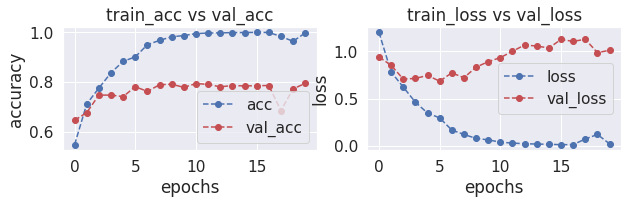

In [18]:
plot_accuracy_loss(history)

We should evaluate the model performance on test set

In [19]:
test_loss = model.evaluate(test_images, test_labels)

3000/3000 [==============================] - 1s 264us/sample - loss: 1.0085 - acc: 0.7837


We see that we achieve 0.76 accuracy on the testing test. We got a slight underfitting :(

Let's see how the classifier is doing on random images.

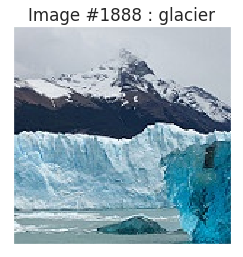

In [20]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

## Error analysis

We can try to understand on which kind of images the classifier has trouble.

In [21]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)


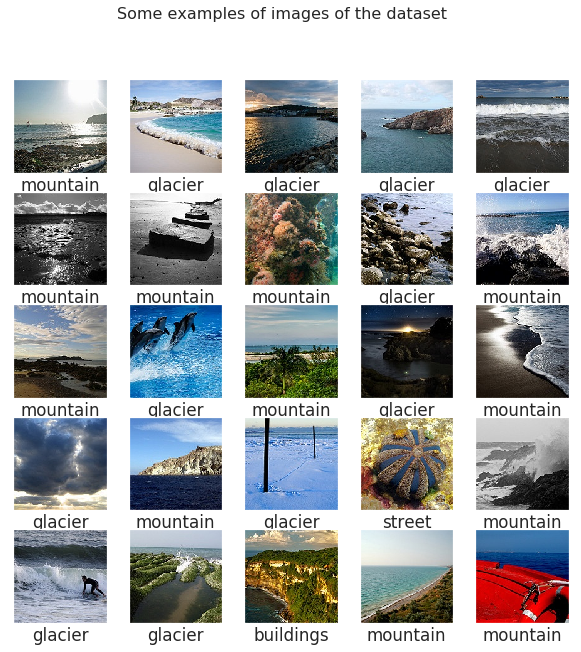

In [22]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

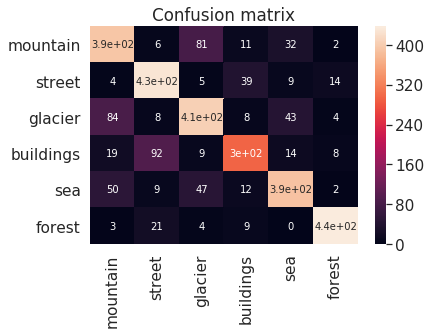

In [23]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

## Conclusion: The classifier has trouble with 2 kinds of images.
It has trouble with street and buildings. Well, it can be understandable as as there are buildings in the street. 
It has also trouble with sea, glacier and moutain as well. It is hard for me to fully distinguish them.
However, it can detects forest very accurately!

**Intermediate Update January 2020**

* Feature extraction with VGG16 trained on ImageNet


* Ensemble models of Neural Networks with the features extracted from VGG

Inspired from: https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/

* Fine Tuning with VGG16 trained on ImageNet

# Feature extraction with VGG ImageNet

We can extract features from VGG16.

In [24]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

Using TensorFlow backend.


58892288/58889256 [==============================] - 0s 0us/step


Get the features directly from VGG16

In [25]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

## Visualize the features through PCA

In [26]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [27]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) # Représentation des individus dans les nouveaux axe
C1 = C[:,0]
C2 = C[:,1]

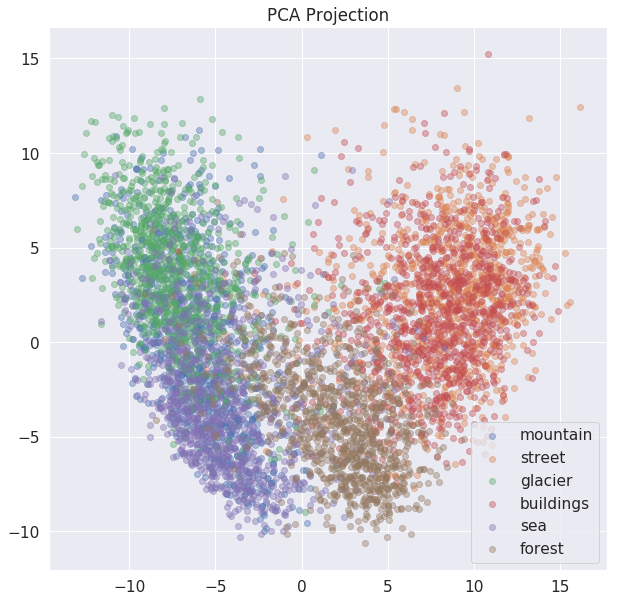

In [28]:
### Figures

plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

We can identifying clusters thanks to this PCA. The clusters correspond more or less to the labels.

We see that glacier and mountain points are very close to each other, as VGG sees them as very similar.

We see that there is no distinction between building and street.
 

## Training on top of VGG

Let's train a simple one-layer Neural Network on the features extracted from VGG.

In [29]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Train on 11227 samples, validate on 2807 samples
Epoch 1/15
11227/11227 [==============================] - 1s 63us/sample - loss: 0.5290 - acc: 0.8075 - val_loss: 0.3963 - val_acc: 0.8554
Epoch 2/15
11227/11227 [==============================] - 0s 44us/sample - loss: 0.3053 - acc: 0.8885 - val_loss: 0.4216 - val_acc: 0.8532
Epoch 3/15
11227/11227 [==============================] - 1s 47us/sample - loss: 0.2421 - acc: 0.9168 - val_loss: 0.3811 - val_acc: 0.8675
Epoch 4/15
11227/11227 [==============================] - 0s 41us/sample - loss: 0.2018 - acc: 0.9282 - val_loss: 0.3396 - val_acc: 0.8807
Epoch 5/15
11227/11227 [==============================] - 0s 44us/sample - loss: 0.1670 - acc: 0.9434 - val_loss: 0.3612 - val_acc: 0.8746
Epoch 6/15
11227/11227 [==============================] - 0s 42us/sample - loss: 0.1497 - acc: 0.9496 - val_loss: 0.3773 - val_acc: 0.8707
Epoch 7/15
11227/11227 [==============================] - 0s 43us/sample - loss: 0.1316 - acc: 0.9570 - val_loss: 0.3

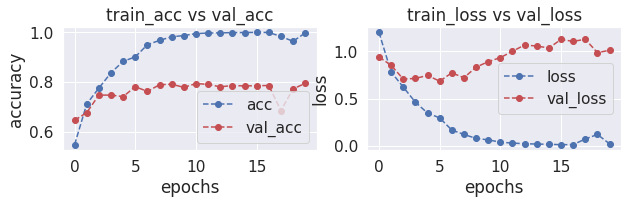

In [30]:
plot_accuracy_loss(history)

We should get approximately 0.844 accuracy (+0.1 accuracy) over the simple ConvNet.

In [31]:
test_loss = model2.evaluate(test_features, test_labels)

3000/3000 [==============================] - 0s 90us/sample - loss: 0.4345 - acc: 0.8730


# Ensemble Neural Networks

In [32]:
np.random.seed(seed=1997)
# Number of estimators
n_estimators = 10
# Proporition of samples to use to train each training
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

We define n_estimators Neural Networks. 

Each Neural Network will be trained on random subsets of the training dataset. Each subset contains max_samples samples.

In [33]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):
    
    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [34]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.1))

Train on 10104 samples, validate on 1123 samples
Epoch 1/10
10104/10104 [==============================] - 1s 70us/sample - loss: 0.5195 - acc: 0.8076 - val_loss: 0.3429 - val_acc: 0.8878
Epoch 2/10
10104/10104 [==============================] - 1s 58us/sample - loss: 0.2550 - acc: 0.9116 - val_loss: 0.3352 - val_acc: 0.8923
Epoch 3/10
10104/10104 [==============================] - 0s 45us/sample - loss: 0.1892 - acc: 0.9349 - val_loss: 0.2939 - val_acc: 0.9074
Epoch 4/10
10104/10104 [==============================] - 0s 44us/sample - loss: 0.1419 - acc: 0.9540 - val_loss: 0.2708 - val_acc: 0.9163
Epoch 5/10
10104/10104 [==============================] - 0s 49us/sample - loss: 0.1097 - acc: 0.9671 - val_loss: 0.2762 - val_acc: 0.9110
Epoch 6/10
10104/10104 [==============================] - 0s 43us/sample - loss: 0.0933 - acc: 0.9721 - val_loss: 0.2816 - val_acc: 0.9225
Epoch 7/10
10104/10104 [==============================] - 0s 42us/sample - loss: 0.0664 - acc: 0.9841 - val_loss: 0.2

We aggregate each model individual predictions to form a final prediction.

In [35]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

We should improve our result as we have a lower variance.

In [36]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.889


# Fine Tuning VGG ImageNet

In [37]:
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [38]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [39]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (9, 9, 512)) # a new input tensor to be able to feed the desired layer
# https://stackoverflow.com/questions/52800025/keras-give-input-to-intermediate-layer-and-get-final-output

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [40]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [41]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 9, 9, 512)         0         
_________________________________________________________________
block5_conv1 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv2 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv3 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 64)          294976    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0         
__________

In [42]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Instructions for updating:
Use tf.cast instead.
Train on 11227 samples, validate on 2807 samples
Epoch 1/10
11227/11227 [==============================] - 6s 532us/step - loss: 0.5956 - acc: 0.7682 - val_loss: 0.4633 - val_acc: 0.8322
Epoch 2/10
11227/11227 [==============================] - 4s 397us/step - loss: 0.3020 - acc: 0.8912 - val_loss: 0.3113 - val_acc: 0.8995
Epoch 3/10
11227/11227 [==============================] - 4s 388us/step - loss: 0.2298 - acc: 0.9160 - val_loss: 0.4231 - val_acc: 0.8703
Epoch 4/10
11227/11227 [==============================] - 4s 390us/step - loss: 0.1940 - acc: 0.9303 - val_loss: 0.3473 - val_acc: 0.8824
Epoch 5/10
11227/11227 [==============================] - 4s 385us/step - loss: 0.1563 - acc: 0.9440 - val_loss: 0.3840 - val_acc: 0.8917
Epoch 6/10
11227/11227 [==============================] - 4s 399us/step - loss: 0.1249 - acc: 0.9563 - val_loss: 0.3742 - val_acc: 0.8928
Epoch 7/10
11227/11227 [==============================] - 4s 396us/step - l

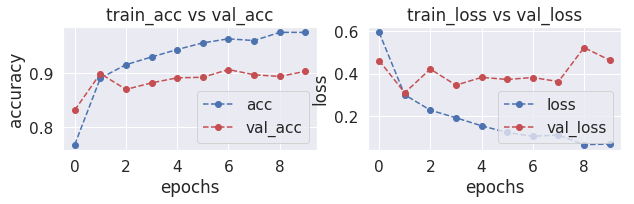

In [43]:
plot_accuracy_loss(history)

In [44]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.8933333333333333
